#Iniciamos código para entrenar red neuronal con arquitectura AlexNet usando PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Definir el dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [2]:
# Transformaciones para el entrenamiento y test
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Descargar y preparar CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Se define la arquitectura AlexNet

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # Redimensionar para el clasificador
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Instanciar el modelo y enviarlo al dispositivo
model = AlexNet(num_classes=10).to(device)
print(model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

#Definición de la función de pérdida y el optimizador

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


#Entrenamiento y evaluación

In [5]:
num_epochs = 15  # Núpero de épocas de entrenamiento

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()           # Limpiar gradientes
        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()                 # Backward pass
        optimizer.step()                # Actualización de parámetros

        running_loss += loss.item()
        if i % 100 == 99:  # Imprimir cada 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluación en el conjunto de test
    correct = 0
    total = 0
    model.eval()  # Modo evaluación
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Época %d, Precisión en test: %.2f %%' % (epoch+1, 100 * correct / total))


[1,   100] loss: 2.303
[1,   200] loss: 2.302
[1,   300] loss: 2.283
Época 1, Precisión en test: 25.70 %
[2,   100] loss: 2.025
[2,   200] loss: 1.917
[2,   300] loss: 1.861
Época 2, Precisión en test: 40.41 %
[3,   100] loss: 1.802
[3,   200] loss: 1.756
[3,   300] loss: 1.735
Época 3, Precisión en test: 45.83 %
[4,   100] loss: 1.687
[4,   200] loss: 1.657
[4,   300] loss: 1.621
Época 4, Precisión en test: 45.21 %
[5,   100] loss: 1.577
[5,   200] loss: 1.542
[5,   300] loss: 1.525
Época 5, Precisión en test: 54.85 %
[6,   100] loss: 1.464
[6,   200] loss: 1.449
[6,   300] loss: 1.436
Época 6, Precisión en test: 59.14 %
[7,   100] loss: 1.372
[7,   200] loss: 1.350
[7,   300] loss: 1.338
Época 7, Precisión en test: 65.94 %
[8,   100] loss: 1.291
[8,   200] loss: 1.269
[8,   300] loss: 1.250
Época 8, Precisión en test: 68.23 %
[9,   100] loss: 1.243
[9,   200] loss: 1.209
[9,   300] loss: 1.179
Época 9, Precisión en test: 69.99 %
[10,   100] loss: 1.153
[10,   200] loss: 1.149
[10,   

In [7]:
# Guardar los pesos del modelo en un archivo
torch.save(model.state_dict(), 'torch_alexnet_weights.pth')
print("Pesos guardados en 'torch_alexnet_weights.pth'")


Pesos guardados en 'torch_alexnet_weights.pth'


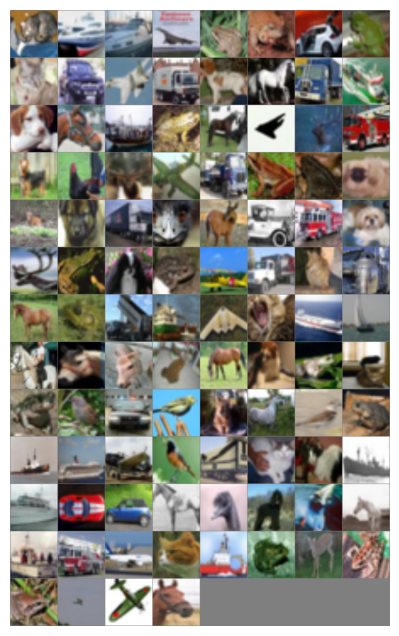

Etiquetas reales:
gato       barco      barco      avión      rana       rana       automóvil  rana       gato       automóvil  avión      camión     perro      caballo    camión     barco      perro      caballo    barco      rana       caballo    avión      ciervo     camión     perro      pájaro     ciervo     avión      camión     rana       rana       perro      ciervo     perro      camión     pájaro     ciervo     automóvil  camión     perro      ciervo     rana       perro      rana       avión      camión     gato       camión     caballo    rana       camión     barco      avión      gato       barco      barco      caballo    caballo    ciervo     rana       caballo    gato       rana       gato       rana       pájaro     automóvil  pájaro     gato       caballo    pájaro     rana       barco      barco      avión      pájaro     camión     gato       gato       barco      barco      automóvil  automóvil  caballo    pájaro     perro      pájaro     caballo    barco      cam

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Definir las clases de CIFAR-10 (orden estándar)
classes = ('avión', 'automóvil', 'pájaro', 'gato',
           'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión')

# Función para desnormalizar y mostrar una imagen
def imshow(img):
    # Desnormalizar: si usamos la normalización (0.5, 0.5, 0.5) tanto para media como para desviación
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Obtener un lote de imágenes del conjunto de test
dataiter = iter(testloader)
images, labels = next(dataiter)

# Mostrar las imágenes originales (desnormalizadas)
imshow(torchvision.utils.make_grid(images, nrow=8))

# Poner el modelo en modo evaluación
model.eval()

# Realizar inferencia sobre el lote (movemos las imágenes al dispositivo adecuado)
with torch.no_grad():
    outputs = model(images.to(device))
    # Obtener la clase predicha para cada imagen
    _, predicted = torch.max(outputs, 1)

# Mostrar las etiquetas reales y las predichas para cada imagen
print("Etiquetas reales:")
print(' '.join(f'{classes[labels[j]]:10s}' for j in range(len(labels))))
print("\nEtiquetas predichas:")
print(' '.join(f'{classes[predicted[j]]:10s}' for j in range(len(predicted))))


Imagen de prueba:


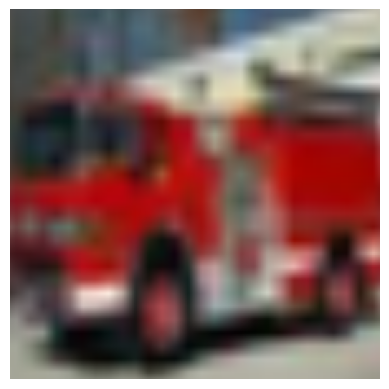

Etiqueta real:     camión
Etiqueta predicha: camión


In [11]:
import matplotlib.pyplot as plt
import torch

# Paso 1: Obtener una imagen y su etiqueta desde el DataLoader de test
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[23]       # Seleccionamos la primera imagen del lote
true_label = labels[23]

# Paso 2: Función para desnormalizar y mostrar la imagen
def imshow(img):
    # Desnormalización: revierte la transformación de normalización (0.5, 0.5, 0.5)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

print("Imagen de prueba:")
imshow(img)

# Paso 3: Realizar la inferencia sobre la imagen
model.eval()  # Poner el modelo en modo evaluación
with torch.no_grad():
    # Agregar dimensión de batch: [1, canales, alto, ancho]
    img_batch = img.unsqueeze(0).to(device)
    output = model(img_batch)
    # Obtener el índice de la clase con la mayor probabilidad
    _, predicted = torch.max(output, 1)

# Paso 4: Comparar la etiqueta real y la predicha
classes = ('avión', 'automóvil', 'pájaro', 'gato',
           'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión')

predicted_label = classes[predicted.item()]
real_label = classes[true_label.item()]

print("Etiqueta real:    ", real_label)
print("Etiqueta predicha:", predicted_label)


#Comparando con modelo preentrenado en ImageNet

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

# Cargar AlexNet preentrenado (entrenado en ImageNet)
alexnet_pretrained = models.alexnet(pretrained=True)

# Ajustar la última capa para CIFAR-10 (10 clases)
num_ftrs = alexnet_pretrained.classifier[6].in_features
alexnet_pretrained.classifier[6] = nn.Linear(num_ftrs, 10)

# Enviar el modelo al dispositivo (GPU/CPU)
alexnet_pretrained = alexnet_pretrained.to(device)
print(alexnet_pretrained)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 183MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Imagen de prueba:


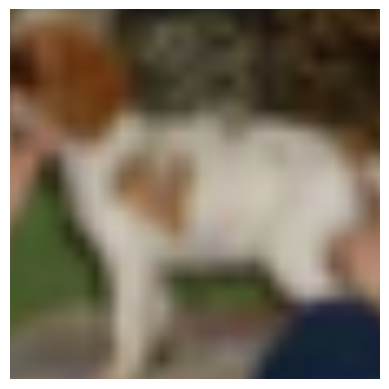

Etiqueta real:                perro
Predicción (modelo entrenado desde cero): gato
Predicción (modelo preentrenado ajustado):   camión


In [15]:
import matplotlib.pyplot as plt
import torchvision

# Definir las clases de CIFAR-10 (orden estándar)
classes = ('avión', 'automóvil', 'pájaro', 'gato',
           'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión')

# Función para desnormalizar y mostrar una imagen (asumiendo normalización (0.5, 0.5, 0.5))
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Paso 1: Obtener una imagen y su etiqueta del DataLoader de test
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[12]       # Seleccionamos la primera imagen del lote
true_label = labels[12]

# Mostrar la imagen
print("Imagen de prueba:")
imshow(img)

# Preparar la imagen (añadir dimensión batch y mover a dispositivo)
img_batch = img.unsqueeze(0).to(device)

# Paso 2: Inferencia con el modelo entrenado desde cero
model.eval()  # Asegurarse de que el modelo esté en modo evaluación
with torch.no_grad():
    output_scratch = model(img_batch)
    _, pred_scratch = torch.max(output_scratch, 1)

# Paso 3: Inferencia con el modelo preentrenado ajustado
alexnet_pretrained.eval()
with torch.no_grad():
    output_pretrained = alexnet_pretrained(img_batch)
    _, pred_pretrained = torch.max(output_pretrained, 1)

# Paso 4: Convertir las predicciones a nombres de clase
pred_scratch_label = classes[pred_scratch.item()]
pred_pretrained_label = classes[pred_pretrained.item()]
real_label = classes[true_label.item()]

print("Etiqueta real:               ", real_label)
print("Predicción (modelo entrenado desde cero):", pred_scratch_label)
print("Predicción (modelo preentrenado ajustado):  ", pred_pretrained_label)


#Lo anterior estaba mal, ya que se quedaba con las características extraídas durante el entrenamiento en ImageNet, lo que no es óptimo para CIFAR‑10.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar AlexNet preentrenado
alexnet_pretrained = models.alexnet(pretrained=True)

# Ajustar la última capa para CIFAR-10 (10 clases)
num_ftrs = alexnet_pretrained.classifier[6].in_features
alexnet_pretrained.classifier[6] = nn.Linear(num_ftrs, 10)
alexnet_pretrained = alexnet_pretrained.to(device)

# Opcional: Congelar las capas convolucionales y las primeras capas del clasificador
for param in alexnet_pretrained.features.parameters():
    param.requires_grad = False

# Si se desea congelar parte del clasificador, se puede hacer de manera similar:
# for param in alexnet_pretrained.classifier[:-1].parameters():
#     param.requires_grad = False

# Definir transformaciones para CIFAR-10 (redimensionar a 224x224 para AlexNet)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar dataset CIFAR-10
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()

# Solo se entrenarán los parámetros que tienen requires_grad=True
optimizer = optim.SGD(filter(lambda p: p.requires_grad, alexnet_pretrained.parameters()),
                      lr=0.001, momentum=0.9)

# Bucle de entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    alexnet_pretrained.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alexnet_pretrained(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Época {epoch+1}, Lote {i+1}, Pérdida: {running_loss/100:.3f}')
            running_loss = 0.0

    # Evaluación en el conjunto de test
    alexnet_pretrained.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alexnet_pretrained(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Epoch {epoch+1}: Precisión en test: {100 * correct/total:.2f}%')


Files already downloaded and verified
Files already downloaded and verified
Época 1, Lote 100, Pérdida: 1.298
Época 1, Lote 200, Pérdida: 0.967
Época 1, Lote 300, Pérdida: 0.898
Epoch 1: Precisión en test: 74.19%
Época 2, Lote 100, Pérdida: 0.821
Época 2, Lote 200, Pérdida: 0.798
Época 2, Lote 300, Pérdida: 0.780
Epoch 2: Precisión en test: 77.31%
Época 3, Lote 100, Pérdida: 0.715
Época 3, Lote 200, Pérdida: 0.753
Época 3, Lote 300, Pérdida: 0.724
Epoch 3: Precisión en test: 78.46%
Época 4, Lote 100, Pérdida: 0.698
Época 4, Lote 200, Pérdida: 0.694
Época 4, Lote 300, Pérdida: 0.689
Epoch 4: Precisión en test: 79.40%
Época 5, Lote 100, Pérdida: 0.668
Época 5, Lote 200, Pérdida: 0.649
Época 5, Lote 300, Pérdida: 0.655
Epoch 5: Precisión en test: 79.97%
Época 6, Lote 100, Pérdida: 0.651
Época 6, Lote 200, Pérdida: 0.637
Época 6, Lote 300, Pérdida: 0.649
Epoch 6: Precisión en test: 80.46%
Época 7, Lote 100, Pérdida: 0.622
Época 7, Lote 200, Pérdida: 0.616
Época 7, Lote 300, Pérdida: 0.604


In [17]:
# Guardar el estado del modelo fine-tuned en un archivo
torch.save(alexnet_pretrained.state_dict(), 'alexnet_cifar10_finetuned.pth')
print("Modelo fine-tuned guardado en 'alexnet_cifar10_finetuned.pth'")


Modelo fine-tuned guardado en 'alexnet_cifar10_finetuned.pth'


In [ ]:
# Crear una instancia del modelo con la misma arquitectura
import torchvision.models as models
import torch.nn as nn

alexnet_pretrained = models.alexnet(pretrained=True)
num_ftrs = alexnet_pretrained.classifier[6].in_features
alexnet_pretrained.classifier[6] = nn.Linear(num_ftrs, 10)
alexnet_pretrained = alexnet_pretrained.to(device)

# Cargar los pesos guardados
alexnet_pretrained.load_state_dict(torch.load('alexnet_cifar10_finetuned.pth'))
alexnet_pretrained.eval()  # Poner el modelo en modo evaluación


Precisión del modelo entrenado desde cero: 77.18%
Precisión del modelo fine-tuned preentrenado:  81.83%


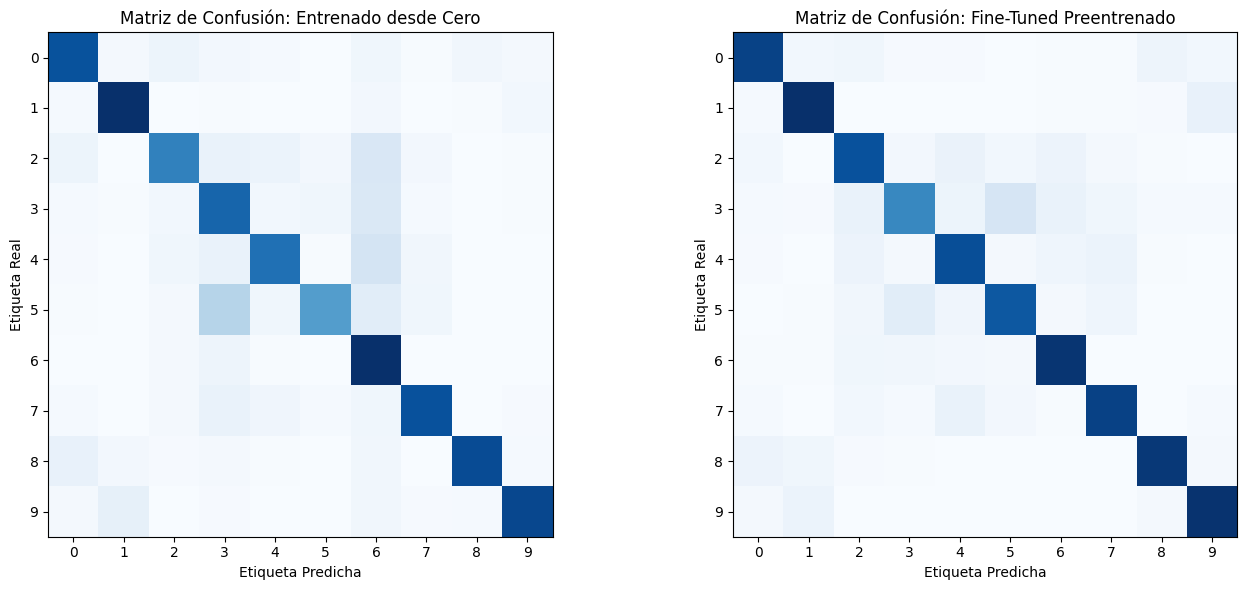

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Función para evaluar el modelo y obtener la precisión
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Función para obtener todas las etiquetas reales y predichas (para la matriz de confusión)
def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds)

# Evaluar ambos modelos en el conjunto de test
accuracy_scratch = evaluate_model(model, testloader, device)
accuracy_finetuned = evaluate_model(alexnet_pretrained, testloader, device)

print("Precisión del modelo entrenado desde cero: {:.2f}%".format(accuracy_scratch))
print("Precisión del modelo fine-tuned preentrenado:  {:.2f}%".format(accuracy_finetuned))

# Obtener etiquetas reales y predichas para la matriz de confusión
labels_scratch, preds_scratch = get_all_preds(model, testloader, device)
labels_finetuned, preds_finetuned = get_all_preds(alexnet_pretrained, testloader, device)

cm_scratch = confusion_matrix(labels_scratch, preds_scratch)
cm_finetuned = confusion_matrix(labels_finetuned, preds_finetuned)

# Opcional: visualizar las matrices de confusión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(cm_scratch, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Matriz de Confusión: Entrenado desde Cero')
ax1.set_xlabel('Etiqueta Predicha')
ax1.set_ylabel('Etiqueta Real')
ax1.set_xticks(np.arange(10))
ax1.set_yticks(np.arange(10))

ax2.imshow(cm_finetuned, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Matriz de Confusión: Fine-Tuned Preentrenado')
ax2.set_xlabel('Etiqueta Predicha')
ax2.set_ylabel('Etiqueta Real')
ax2.set_xticks(np.arange(10))
ax2.set_yticks(np.arange(10))

plt.tight_layout()
plt.show()


Imagen de prueba:


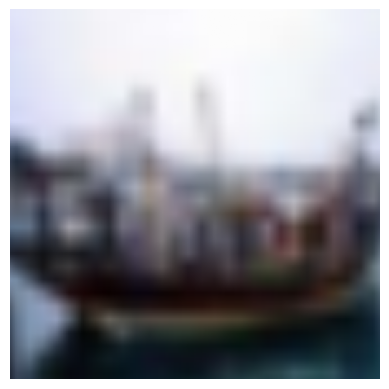

Etiqueta real:                             barco
Predicción (modelo entrenado desde cero): barco
Predicción (modelo preentrenado ajustado):   barco


In [20]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch

# Definir las clases de CIFAR-10 (orden estándar)
classes = ('avión', 'automóvil', 'pájaro', 'gato',
           'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión')

# Función para desnormalizar y mostrar una imagen (asumiendo normalización (0.5, 0.5, 0.5))
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Paso 1: Obtener una imagen y su etiqueta del DataLoader de test
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[18]       # Seleccionamos la imagen de índice 12 del lote
true_label = labels[18]

# Mostrar la imagen
print("Imagen de prueba:")
imshow(img)

# Preparar la imagen (añadir dimensión batch y moverla al dispositivo: CPU/GPU)
img_batch = img.unsqueeze(0).to(device)

# Paso 2: Inferencia con el modelo entrenado desde cero
model.eval()  # Poner el modelo en modo evaluación
with torch.no_grad():
    output_scratch = model(img_batch)
    _, pred_scratch = torch.max(output_scratch, 1)

# Paso 3: Inferencia con el modelo preentrenado ajustado para CIFAR10
alexnet_pretrained.eval()
with torch.no_grad():
    output_pretrained = alexnet_pretrained(img_batch)
    _, pred_pretrained = torch.max(output_pretrained, 1)

# Paso 4: Convertir las predicciones a nombres de clase
pred_scratch_label = classes[pred_scratch.item()]
pred_pretrained_label = classes[pred_pretrained.item()]
real_label = classes[true_label.item()]

print("Etiqueta real:                            ", real_label)
print("Predicción (modelo entrenado desde cero):", pred_scratch_label)
print("Predicción (modelo preentrenado ajustado):  ", pred_pretrained_label)
